In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install pytorch-forecasting

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, Callback
from pytorch_forecasting import TimeSeriesDataSet, NBeats, Baseline, DeepAR, GroupNormalizer, MultiNormalizer, EncoderNormalizer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import MAPE, MAE, MASE, RMSE
from pytorch_forecasting.metrics import NormalDistributionLoss

In [3]:
class EpochCallback(Callback):
        
    def on_validation_epoch_end(self, trainer, module):
        print(trainer.progress_bar_metrics)

In [4]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

## Data Loading

In [68]:
btc_df = pd.read_csv('BTC-USD.csv')
eth_df = pd.read_csv('ETH-USD.csv')
sp500_df = pd.read_csv('S&P 500 Historical Data.csv')

In [69]:
btc_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


## Data Splitting

In [70]:
train_size = 0.8

train_df = btc_df.iloc[:int(len(btc_df)*train_size)]
test_df = btc_df.iloc[int(len(btc_df)*train_size):]

## Data Formatting

In [71]:
lag_time = 60 # num of steps input to the model >= lead time, x1, x2, ...
lead_time = 7 # lookahead, predicting horizon. 
train_df = train_df.reset_index().rename({'index':'time_idx'}, axis=1)
test_df = test_df.reset_index().rename({'index':'time_idx'}, axis=1)

train_df['group_ids'] = 0
test_df['group_ids'] = 0

In [72]:
train_df

,time_idx,Date,Open,High,Low,Close,Adj Close,Volume,group_ids
0,0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,0
1,1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,0
2,2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,0
3,3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0
4,4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,0
...,...,...,...,...,...,...,...,...,...
2386,2386,2021-03-30,57750.132813,59447.222656,57251.550781,58917.691406,58917.691406,54414116432,0
2387,2387,2021-03-31,58930.277344,59930.027344,57726.417969,58918.832031,58918.832031,65520826225,0
2388,2388,2021-04-01,58926.562500,59586.070313,58505.277344,59095.808594,59095.808594,61669163792,0
2389,2389,2021-04-02,59098.878906,60267.187500,58869.281250,59384.312500,59384.312500,58727860620,0


## Data Preparation for N-BEATS

In [73]:
train_df_nbeats = train_df.melt(id_vars=['time_idx', 'Date'], value_vars='Adj Close', var_name='group_ids')
train_df_nbeats.head()

,time_idx,Date,group_ids,value
0,0,2014-09-17,Adj Close,457.334015
1,1,2014-09-18,Adj Close,424.440002
2,2,2014-09-19,Adj Close,394.795990
3,3,2014-09-20,Adj Close,408.903992
4,4,2014-09-21,Adj Close,398.821014


In [74]:
train_df_nbeats.tail()

,time_idx,Date,group_ids,value
2386,2386,2021-03-30,Adj Close,58917.691406
2387,2387,2021-03-31,Adj Close,58918.832031
2388,2388,2021-04-01,Adj Close,59095.808594
2389,2389,2021-04-02,Adj Close,59384.312500
2390,2390,2021-04-03,Adj Close,57603.890625


In [75]:
# define dataset
valid_size = 0.25  
max_encoder_length = lag_time
max_prediction_length = lead_time
training_cutoff = train_df_nbeats["time_idx"][:int((1 - valid_size)*train_df_nbeats["time_idx"].max())].values[-1]
context_length = max_encoder_length
prediction_length = max_prediction_length

In [76]:
training = TimeSeriesDataSet(
    train_df_nbeats.loc[train_df_nbeats.time_idx <= training_cutoff],  # Applying the training cutoff
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(train_df_nbeats.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["value"],
)

In [77]:
validation = TimeSeriesDataSet.from_dataset(training, train_df_nbeats, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Model Training

In [78]:
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
epoch_callback = EpochCallback()

trainer = pl.Trainer(
    max_epochs=50,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback, epoch_callback],
    limit_train_batches=1.0,
)

net = NBeats.from_dataset(
    training,
    learning_rate=1e-4,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    # widths=[16, 16],
    # backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.771     Total estimated model params size (MB)
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_l

Validation sanity check: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42


{'sanity_check_loss': 5.444847106933594}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

{'train_loss_step': 6.553344249725342, 'val_loss': 7.2239885330200195}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 5.818490028381348, 'val_loss': 7.166445255279541, 'train_loss_epoch': 6.649770736694336}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 6.241393089294434, 'val_loss': 7.073439121246338, 'train_loss_epoch': 6.67376708984375}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 6.997035503387451, 'val_loss': 6.948208332061768, 'train_loss_epoch': 6.5823259353637695}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 6.118929862976074, 'val_loss': 6.79206657409668, 'train_loss_epoch': 6.48165225982666}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 5.835680961608887, 'val_loss': 6.685155868530273, 'train_loss_epoch': 6.315478801727295}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 6.146267414093018, 'val_loss': 6.481818675994873, 'train_loss_epoch': 6.254128456115723}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 6.4124436378479, 'val_loss': 6.250250816345215, 'train_loss_epoch': 6.131499290466309}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 5.188388824462891, 'val_loss': 5.990411758422852, 'train_loss_epoch': 5.89896297454834}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 5.517178058624268, 'val_loss': 5.704448699951172, 'train_loss_epoch': 5.764490127563477}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 4.753746032714844, 'val_loss': 5.406983375549316, 'train_loss_epoch': 5.549290180206299}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 4.672390460968018, 'val_loss': 5.233394145965576, 'train_loss_epoch': 5.3730974197387695}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 5.461582660675049, 'val_loss': 4.947134494781494, 'train_loss_epoch': 5.129663467407227}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 4.858901023864746, 'val_loss': 4.684598922729492, 'train_loss_epoch': 4.9228901863098145}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 4.179732799530029, 'val_loss': 4.45231819152832, 'train_loss_epoch': 4.757343292236328}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 4.199034214019775, 'val_loss': 4.254426002502441, 'train_loss_epoch': 4.539044380187988}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 3.9862961769104004, 'val_loss': 4.090396881103516, 'train_loss_epoch': 4.353151321411133}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 4.298825263977051, 'val_loss': 4.003130912780762, 'train_loss_epoch': 4.15445613861084}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 3.8288938999176025, 'val_loss': 3.8668742179870605, 'train_loss_epoch': 4.006804466247559}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 3.869069814682007, 'val_loss': 3.738352060317993, 'train_loss_epoch': 3.8592469692230225}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 3.5649116039276123, 'val_loss': 3.6144542694091797, 'train_loss_epoch': 3.7276129722595215}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 3.8527259826660156, 'val_loss': 3.49513578414917, 'train_loss_epoch': 3.614638090133667}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 3.39028000831604, 'val_loss': 3.369805335998535, 'train_loss_epoch': 3.4797985553741455}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 3.5138118267059326, 'val_loss': 3.30485463142395, 'train_loss_epoch': 3.3902478218078613}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.9702517986297607, 'val_loss': 3.214259624481201, 'train_loss_epoch': 3.2878191471099854}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 3.378499984741211, 'val_loss': 3.1443657875061035, 'train_loss_epoch': 3.2101807594299316}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 3.2486438751220703, 'val_loss': 3.0980629920959473, 'train_loss_epoch': 3.1279072761535645}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.842916250228882, 'val_loss': 3.0397610664367676, 'train_loss_epoch': 3.0558876991271973}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.9604649543762207, 'val_loss': 2.9924094676971436, 'train_loss_epoch': 3.009068727493286}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 3.0989902019500732, 'val_loss': 2.983311891555786, 'train_loss_epoch': 2.994331121444702}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 3.388643503189087, 'val_loss': 2.9352760314941406, 'train_loss_epoch': 2.913093090057373}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.7863807678222656, 'val_loss': 2.910123825073242, 'train_loss_epoch': 2.894566774368286}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.8928768634796143, 'val_loss': 2.878178834915161, 'train_loss_epoch': 2.837094306945801}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.7658824920654297, 'val_loss': 2.851095199584961, 'train_loss_epoch': 2.823749303817749}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.707934856414795, 'val_loss': 2.804906129837036, 'train_loss_epoch': 2.7678205966949463}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.889582872390747, 'val_loss': 2.7929906845092773, 'train_loss_epoch': 2.7511391639709473}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.647111415863037, 'val_loss': 2.785489082336426, 'train_loss_epoch': 2.7079484462738037}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.73323392868042, 'val_loss': 2.763651132583618, 'train_loss_epoch': 2.721654176712036}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.9136805534362793, 'val_loss': 2.738515615463257, 'train_loss_epoch': 2.708096742630005}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.5803966522216797, 'val_loss': 2.7232837677001953, 'train_loss_epoch': 2.6727399826049805}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.8310205936431885, 'val_loss': 2.702329158782959, 'train_loss_epoch': 2.6624293327331543}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.612244129180908, 'val_loss': 2.6913464069366455, 'train_loss_epoch': 2.6268467903137207}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.953747272491455, 'val_loss': 2.6721067428588867, 'train_loss_epoch': 2.619694232940674}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.5882985591888428, 'val_loss': 2.6644418239593506, 'train_loss_epoch': 2.610762119293213}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.308459758758545, 'val_loss': 2.6573290824890137, 'train_loss_epoch': 2.617574453353882}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.4765994548797607, 'val_loss': 2.6435136795043945, 'train_loss_epoch': 2.5774130821228027}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.2826836109161377, 'val_loss': 2.629194974899292, 'train_loss_epoch': 2.585824489593506}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.627723455429077, 'val_loss': 2.6284420490264893, 'train_loss_epoch': 2.5608766078948975}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.728477954864502, 'val_loss': 2.619696617126465, 'train_loss_epoch': 2.56017804145813}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.4454398155212402, 'val_loss': 2.6025476455688477, 'train_loss_epoch': 2.5150034427642822}


## Testing

In [79]:
test_dataset = TimeSeriesDataSet(
    test_df,
    time_idx="time_idx",
    target="Adj Close",
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["Adj Close"],
)

test_dataloader = test_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

In [80]:
len(test_dataset)

532

In [81]:
test_dataloader

In [82]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)
print(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = best_model.predict(test_dataloader)

/ssd003/home/irisli/forecasting-bootcamp/ScotiaTeam3_demo2/lightning_logs/version_8825851/checkpoints/epoch=49-step=649-v1.ckpt


## Plot Model Forecasts at Max Lead Time

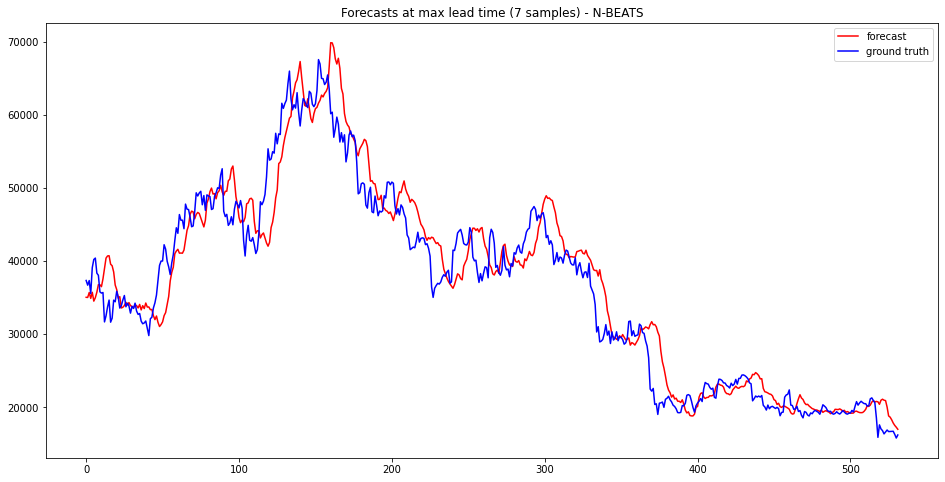

In [90]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

indexes = []
preds = []
trues = []

for time_idx in range(actuals_np.shape[0]):
    indexes.append(time_idx)
    preds.append(predictions_np[time_idx][-1])
    trues.append(actuals_np[time_idx][-1])

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(indexes, preds, color='red', label='forecast')
ax.plot(indexes, trues, color='blue', label='ground truth')
ax.set_title(f"Forecasts at max lead time ({lead_time} samples) - N-BEATS")
ax.legend()

In [84]:
actuals_np.shape

(532, 7)

In [85]:
len(predictions_np)

532

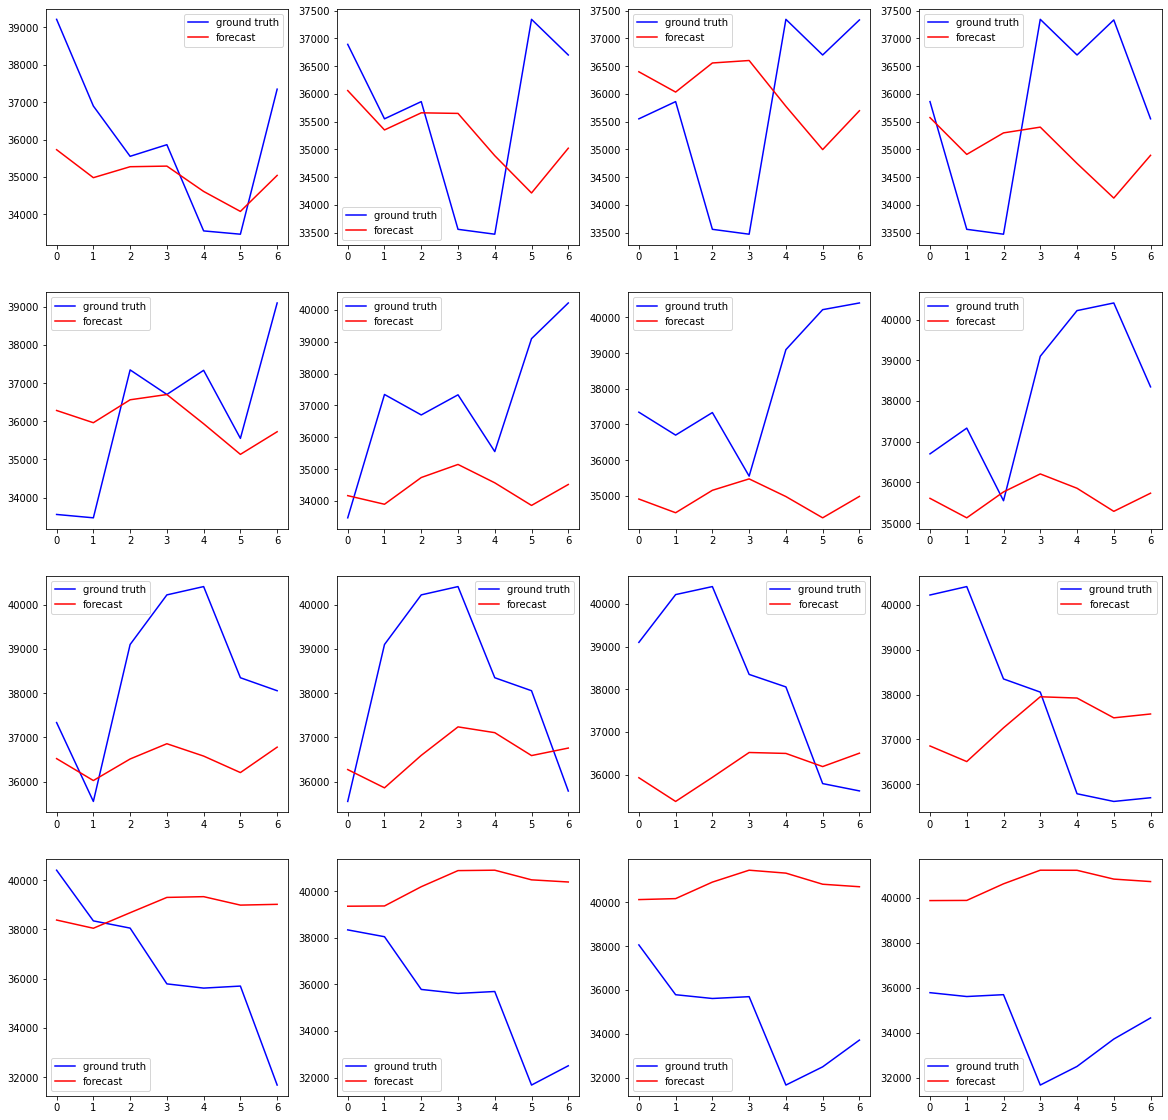

In [86]:
# plot at single time index

fig, axs = plt.subplots(4, 4, figsize=(20,20))
axs = axs.flatten()

for fig_index, example_index in enumerate(range(0, len(predictions_np), 1)):

    if fig_index > len(axs) - 1:
        break

    ground_truth = actuals_np[example_index]
#     print(ground_truth)
    forecast = predictions_np[example_index]
#     print(forecast)

    axs[fig_index].plot(list(range(0, len(forecast))), ground_truth, color='blue', label='ground truth')
    axs[fig_index].plot(list(range(0, len(forecast))), forecast, color='red', label='forecast')
    axs[fig_index].legend()

## Standard evaluation metrics

In [87]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

metrics = {
    'mse': mean_squared_error,
    'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error
}

def compute_error_statistics(error_metrics_dict, exp_name):
    return {
        'mean': pd.DataFrame(error_metrics_dict).mean(axis=0).rename(f'{exp_name}_mean_metrics'),
        'std': pd.DataFrame(error_metrics_dict).std(axis=0).rename(f'{exp_name}_std_metrics'),
        'max': pd.DataFrame(error_metrics_dict).max(axis=0).rename(f'{exp_name}_max_metrics'),
    }

def compute_baseline_error_metrics(predictions, actuals):

    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(predictions)):
    
        for metric_name, metric_fn in metrics.items(): 
                errors[metric_name].append(metric_fn(y_true=actuals[i], y_pred=predictions[i]))

    return errors

In [88]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

nbeats_errors = compute_baseline_error_metrics(predictions_np, actuals_np)
nbeats_stats = compute_error_statistics(nbeats_errors, 'nbeats')
nbeats_stats['mean']

mse     8.934034e+06
rmse    2.393725e+03
mae     2.123357e+03
mape    5.916091e-02
Name: nbeats_mean_metrics, dtype: float32